# IDS-IPS with Deep Learning

Our goal is to build a proof-of-concept model that mimics an IDS-IPS system by predicting whether a stream of network data is malicious or benign. Common IDS-IPS systems use signature-based detection that flags previously-identified malicious network activities. While there are anomaly-based IDS-IPS systems, they often use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or Gaussian Mixture Models to identify outliers. In this notebook, I will attempt to build a DNN that identifies anomalies in network activity and perform classification. In addition, I will also build an autoencoder network, PCA, DBSCAN, K-Means Clustering and a Gaussian Mixture Model for benchmark purpsoes.

The dataset we're using is from ISCX 2017. 

> CICIDS2017 dataset contains benign and the most up-to-date common attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter with labeled flows based on the time stamp, source and destination IPs, source and destination ports, protocols and attack (CSV files).

# EDA

In [1]:
# Essentials
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
pd.set_option("display.precision", 2)

# MLxtend
from mlxtend.feature_selection import ColumnSelector

# Models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import tree

# Misc
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy.spatial.distance import cdist
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Here, we take a look at how many CSV files we have
print(os.listdir('data'))

['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']


First, let's load in the dataset and have a look at the raw data. Since we have multiple csv files, I'll load them all at once and concatenate them into one giant dataframe

In [3]:
df_list = []
for filename in os.listdir('data'):
    df = pd.read_csv('data/'+filename, index_col=None)
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)

df.shape

(2830743, 79)

At a quick glance, we have 2830743 entries, 78 features and 1 label for the class of the network data. Let's take a closer look at the data. Here, we can see that there are a lot of pre-calculated mean, max, min, std.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

Before we go any further, let's rename the columns so that we can access our column data easier.

In [5]:
df.rename(columns=lambda x: x.lower().lstrip()
          .rstrip().replace(" ", "_"), inplace=True)
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

Here, we can see that `Flow Bytes/s`, `Flow Packets/s` and `Labels` are all objects, let's convert the types first

In [6]:
df['flow_bytes/s'] = df['flow_bytes/s'].astype('float64')
df['flow_packets/s'] = df['flow_packets/s'].astype('float64')

As we can see, the data is highly imbalanced. This is actually a huge problem in IDS/IPS models since these imbalanced datasets give rise to a high number of false positives and false negatives. My reasoning would be optimizing the model without overfitting, and allowing more false positives than false negatives.

Better safe than sorry...

In [7]:
df.label.value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: label, dtype: int64

Finally, let's visualize some of the features to see if there are any interesting distribution / trends.

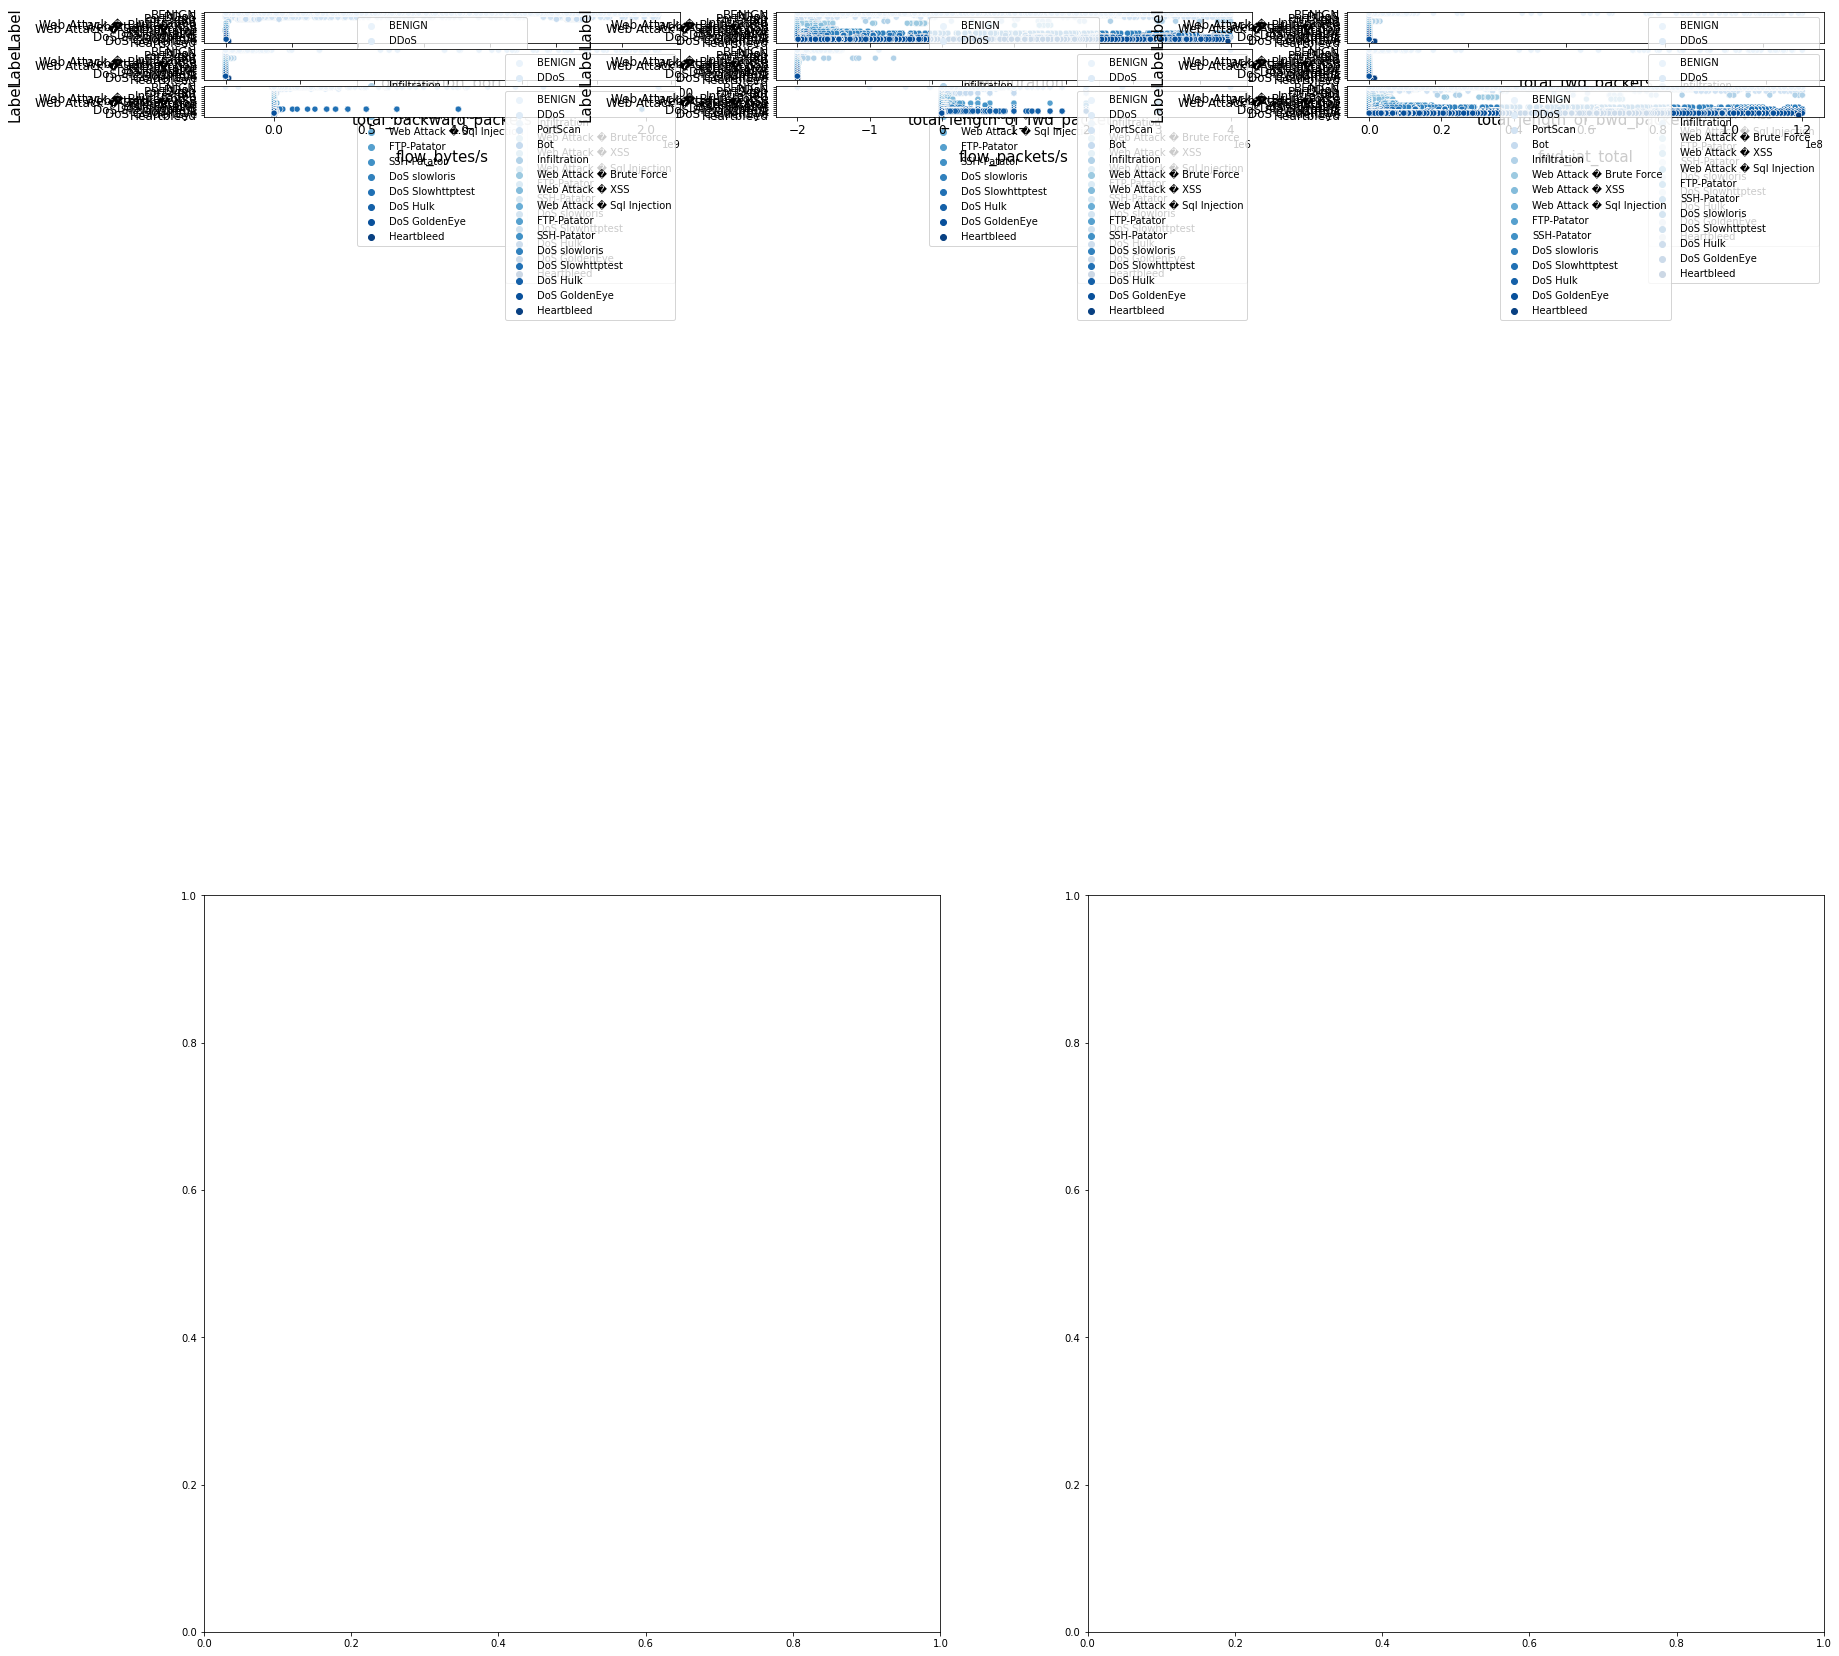

In [8]:
numeric_dtypes = ['int64', 'float64']
numeric = []

# We just want the total instead of the pre-calculated features
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        if 'mean' in i or 'min' in i or 'max' in i or 'std' in i or 'variance' in i:
            pass
        else:
            numeric.append(i)

# visualising data
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)

for i, feature in enumerate(list(df[numeric]), 1):
    if i == 10:
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='label', hue='label', palette='Blues', data=df)
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('Label', size=15, labelpad=12.5)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()
        

Last but not least, a quick look at the correlation between features.

<AxesSubplot:>

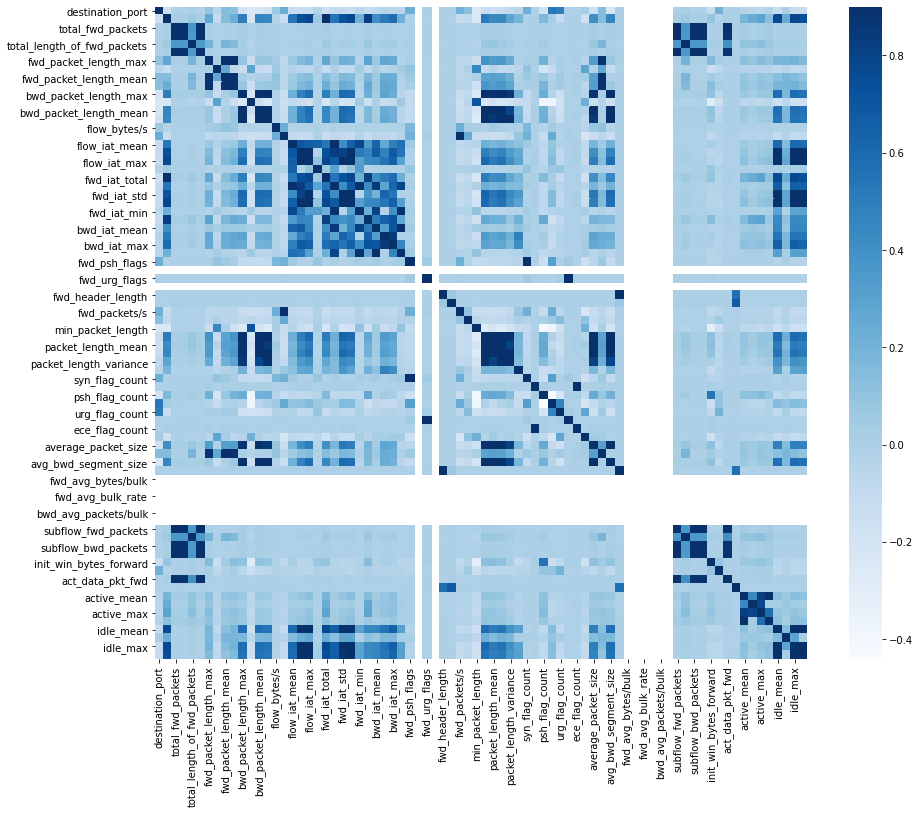

In [9]:
correlation = df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(correlation, vmax=0.9, cmap="Blues", square=True)

## Feature Engineering

First, we will remove all the pre-calculated mean, variance, std, min and max values for a smaller feature space.

In [10]:
cols = [col for col in list(df.columns) if 'mean' not in col and 'variance' not in col 
            and 'std' not in col and 'min' not in col and 'max' not in col]
df = df[cols]

Before we drop all missing values, we first procede to encode the categorical labels.

In [11]:
# For categorical labels, one hot encode
encoder = LabelEncoder()
categorical_labels = (encoder.fit_transform(df.label))
print({i:label for i,label in enumerate(encoder.classes_)})
df = pd.concat([df.drop(['label'], 1),
          pd.DataFrame({'label': categorical_labels})], axis=1).reindex()
df.head()

{0: 'BENIGN', 1: 'Bot', 2: 'DDoS', 3: 'DoS GoldenEye', 4: 'DoS Hulk', 5: 'DoS Slowhttptest', 6: 'DoS slowloris', 7: 'FTP-Patator', 8: 'Heartbleed', 9: 'Infiltration', 10: 'PortScan', 11: 'SSH-Patator', 12: 'Web Attack � Brute Force', 13: 'Web Attack � Sql Injection', 14: 'Web Attack � XSS'}


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,flow_bytes/s,flow_packets/s,fwd_iat_total,bwd_iat_total,...,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,label
0,54865,3,2,0,12,0,4.00e+06,666666.67,3,0,...,0,0,2,12,0,0,33,-1,1,0
1,55054,109,1,1,6,6,1.10e+05,18348.62,0,0,...,0,0,1,6,1,6,29,256,0,0
2,55055,52,1,1,6,6,2.31e+05,38461.54,0,0,...,0,0,1,6,1,6,29,256,0,0
3,46236,34,1,1,6,6,3.53e+05,58823.53,0,0,...,0,0,1,6,1,6,31,329,0,0
4,54863,3,2,0,12,0,4.00e+06,666666.67,3,0,...,0,0,2,12,0,0,32,-1,1,0


In [12]:
# Finding missing values
def percent_missing(df_cols):
    dict_x = {}
    for i in range(0,len(df_cols)):
        dict_x.update({df_cols[i]: round(df[df_cols[i]].isnull().mean()*100,2)})
    return dict_x

missing = percent_missing(df.drop(['label'], axis=1).columns)
df_miss = sorted(missing.items(), key=lambda kv: kv[1], reverse=True)
print('Percent of missing data')
print(df_miss[0:10])

Percent of missing data
[('flow_bytes/s', 0.05), ('destination_port', 0.0), ('flow_duration', 0.0), ('total_fwd_packets', 0.0), ('total_backward_packets', 0.0), ('total_length_of_fwd_packets', 0.0), ('total_length_of_bwd_packets', 0.0), ('flow_packets/s', 0.0), ('fwd_iat_total', 0.0), ('bwd_iat_total', 0.0)]


In [13]:
# find all infinite or -infinite values
df = df.replace([np.inf, -np.inf], np.nan)
# Drop all nan values and remaining non-finite values
df = df[~np.any(np.isnan(df), axis=1)]
df = df[np.all(np.isfinite(df), axis=1)]
# Make sure the dataframe is clean
print(np.any(pd.isnull(df))) # Should be False
print(np.all(np.isfinite(df.loc[:, df.columns != 'label']))) # Should be True

False
True


In [14]:
df.shape

(2827876, 45)

In [15]:
numerical_cols = df[[i for i in list(df.columns) if 'label' not in i]]
target_variables = df.label
numerical_cols.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,flow_bytes/s,flow_packets/s,fwd_iat_total,bwd_iat_total,...,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd
0,54865,3,2,0,12,0,4.00e+06,666666.67,3,0,...,0,0,0,2,12,0,0,33,-1,1
1,55054,109,1,1,6,6,1.10e+05,18348.62,0,0,...,0,0,0,1,6,1,6,29,256,0
2,55055,52,1,1,6,6,2.31e+05,38461.54,0,0,...,0,0,0,1,6,1,6,29,256,0
3,46236,34,1,1,6,6,3.53e+05,58823.53,0,0,...,0,0,0,1,6,1,6,31,329,0
4,54863,3,2,0,12,0,4.00e+06,666666.67,3,0,...,0,0,0,2,12,0,0,32,-1,1


['destination_port' 'flow_duration' 'total_length_of_fwd_packets'
 'flow_bytes/s' 'flow_packets/s' 'fwd_iat_total' 'bwd_iat_total'
 'fwd_psh_flags' 'fwd_packets/s' 'bwd_packets/s' 'fin_flag_count'
 'syn_flag_count' 'psh_flag_count' 'ack_flag_count' 'urg_flag_count'
 'down/up_ratio']


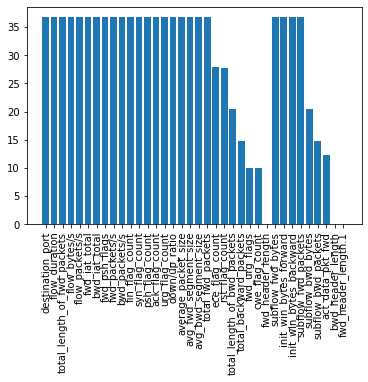

In [16]:
best_features = SelectPercentile(f_classif, percentile=10)
fit = best_features.fit(numerical_cols, target_variables)
scores = -np.log10(fit.pvalues_)
score_dicts = dict(zip(numerical_cols.columns, scores))
sorted_score_dicts = sorted(score_dicts.items(), key=lambda x: x[1], reverse=True)

# Use a dataframe for easier processing
sorted_score_df = pd.DataFrame(sorted_score_dicts).dropna().reset_index(drop=True)
sorted_score_df = sorted_score_df.replace(np.inf, np.max(sorted_score_df[sorted_score_df != np.inf]))

# Get feature columns for future use
selected_features = np.array(sorted_score_df.loc[:15, 0])
print(selected_features)

# Plotting feature significance
fig = plt.bar(sorted_score_df[0], sorted_score_df[1]) 
plt.xticks(rotation=90)
plt.show()

## Exploring with KMeans & PCA

Even though that we've trimmed down the features to 15, we would use 45 features first. Then, we can start fitting them in different models and evaluating their performance. 

The problem with having 15 features is the highly imbalanced dataset...

> First, we'll attempt to explore the data further thru clustering and PCA analysis.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(numerical_cols,target_variables,test_size=0.2, random_state=42)

print(np.any(np.isnan(X_train)))
print(np.all(np.isfinite(X_train)))

False
True


## Preparation for model building thru KMeans clustering and PCA decomposition

In [18]:
# First, we need to name the index to make sure the pca indices match up to the y-labels
X_train = X_train.rename_axis('index')
X_test = X_test.rename_axis('index')
y_train = y_train.rename_axis('index')
y_test = y_test.rename_axis('index')

In [19]:
pca_train = PCA(n_components=2)
pca_train.fit(X_train)
print(pca_train.explained_variance_ratio_)
pca_train_data = pca_train.transform(X_train)

[0.60553707 0.2084812 ]


As we can see, the first component accounts for about 59.6% meaning of the data whilst the second accounts for about 21%. The total information lost would be around 100-97 = 3%

In [20]:
pca_train_df = pd.DataFrame(data = pca_train_data
             , columns = ['principal_component_1', 'principal_component_2'], index=X_train.index)
pca_train_df = pd.concat([pca_train_df,y_train], axis=1)
pca_train_df.head(5)

,principal_component_1,principal_component_2,label
index,,,
568457,-2.27e+07,-39556.90,0
25609,-2.08e+07,-39205.82,2
334622,-2.29e+07,-39485.37,10
993727,-2.29e+07,-39504.44,0
1575255,-2.29e+07,-39488.32,0


Here, we have to drop the nan columns again due to varaible lost in PCA.

In [21]:
pca_train_df = pca_train_df.replace([np.inf, -np.inf], np.nan)
pca_train_df.dropna(axis=0, inplace=True)
print(np.any(pd.isnull(pca_train_df))) # Should be False
print(np.all(np.isfinite(pca_train_df))) # Should be True

False
True


An initial look at the data:

In [22]:
len(encoder.classes_)

15

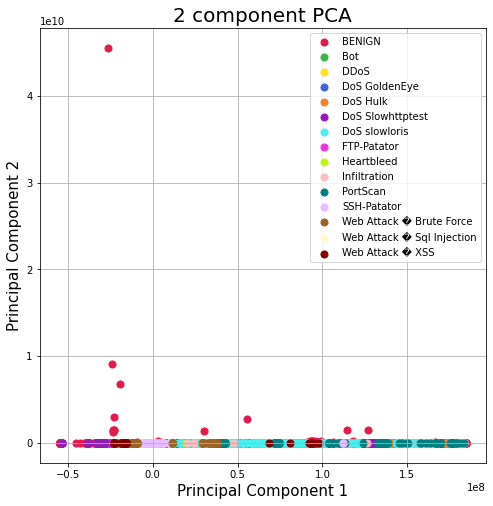

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14]
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000']
for target, color in zip(targets,colors):
    indicesToKeep = pca_train_df['label'] == target
    ax.scatter(pca_train_df.loc[indicesToKeep, 'principal_component_1']
               , pca_train_df.loc[indicesToKeep, 'principal_component_2']
               , c = color
               , s = 50)
ax.legend(encoder.classes_)
ax.grid()

> We can see that it is rather hard for the kmeans algorithm to assign clusters as there would be too much overlapping and lead to false positives. This either attributes to inseparable features between infiltration and normal network activity, or the poor feature selection on my part.

Here, we will proceed again with the elbow method and try clustering to determine anomalies.

In [24]:
pca_train_df.shape

(2262300, 3)

### Using Elbow method to determine k-value

In [25]:
def eval_kmeans(k, dataset, **kwargs):
    estimator = KMeans(random_state=42, n_clusters=k)
    estimator.fit(dataset)
    return sum(np.min(cdist(dataset, estimator.cluster_centers_, 
                 'euclidean'),axis=1)) / dataset.shape[0] 

range_k = range(5,100,25)
res = {}
for k in range_k:
    res[k] = (eval_kmeans(k, pca_train_df))
    
print(res)

{5: 4450843.121307705, 30: 426241.6591106042, 55: 263811.1530287731, 80: 182012.91403925687}


Text(0.5, 1.0, 'Percentage variance by. K')

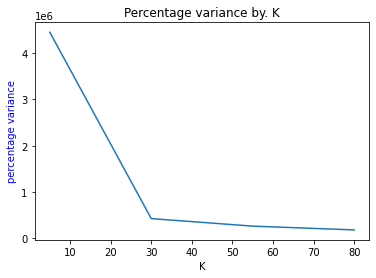

In [26]:
fig, ax = plt.subplots()
ax.plot([c[0] for c in res.items()], [c[1] for c in res.items()])
ax.set_ylabel('percentage variance', color='blue')
plt.xlabel("K")
plt.title("Percentage variance by. K")

> Hence, we will use k=30 since it is the point where the sum of squared error between the points and cluster centers reach the elbow point. 

## Testing different model accuracies after kmeans clustering of decomposited features

In [27]:
# Now, we establish a pca df for the testing dataset and attempt to predict its values after cluster labelling.
pca_test = PCA(n_components=2)
pca_test.fit(X_test)
print(pca_test.explained_variance_ratio_)
pca_test_data = pca_test.transform(X_test)
# Setting up the testing df
pca_test_df = pd.DataFrame(data = pca_test_data
             , columns = ['principal_component_1', 'principal_component_2'], index=X_test.index)
pca_test_df.rename_axis('index')
pca_test_df = pd.concat([pca_test_df, y_test], axis=1)
pca_test_df.head()

[0.66730186 0.16936596]


,principal_component_1,principal_component_2,label
index,,,
176112,-1.08e+07,-1.66e+06,0
264817,-2.28e+07,-1.88e+06,0
205084,8.24e+07,-1.31e+05,0
1368918,-2.29e+07,-1.61e+06,0
2720654,-2.29e+07,-1.88e+06,0


In [28]:
estimator_kmeans = KMeans(n_clusters=30, random_state=42)
estimator_kmeans.fit(pca_train_df.loc[:,['principal_component_1', 'principal_component_2']])

# Setting up y_labels for training and testing data
y_pred_train = estimator_kmeans.labels_
y_pred_test = estimator_kmeans.predict(pca_test_df.loc[:, ['principal_component_1', 'principal_component_2']])

In [29]:
# Adding cluster info into X training and testing set
X_train['km_clust'] = y_pred_train
X_test['km_clust'] = y_pred_test

### Logistic Regression w/o clusters

Accuracy: 0.7833429989957141


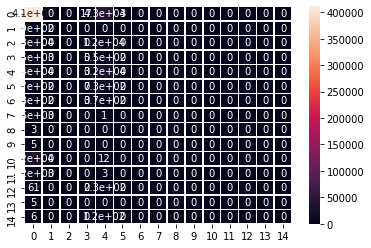

In [30]:
X_train_no_clust = X_train.drop('km_clust', axis=1)
X_test_no_clust = X_test.drop('km_clust', axis=1)

# model
lr_model_nc = LogisticRegression(random_state=42)
lr_model_nc.fit(X_train_no_clust, y_train)
y_pred_nc = lr_model_nc.predict(X_test_no_clust)

# evaluation
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_nc)))
c_matrix = confusion_matrix(y_test, y_pred_nc)
fig, ax = plt.subplots()
ax = sns.heatmap(c_matrix,annot=True,linewidths=.5)
plt.show()

In [31]:
def eval_metrics(c_matrix):
    FP = c_matrix.sum(axis=0) - np.diag(c_matrix)  
    FN = c_matrix.sum(axis=1) - np.diag(c_matrix)
    TP = np.diag(c_matrix)
    TN = c_matrix.sum() - (FP + FN + TP)
    print((" False Positives: {}\n False Negatives: {}\n True Positives: {}\n True Negatives: {} \n")
          .format(FP.sum(), FN.sum(), TP.sum(), TN.sum()))
eval_metrics(c_matrix)

 False Positives: 122536
 False Negatives: 122536
 True Positives: 443040
 True Negatives: 7795528 



### Logistic Regression w/ KMeans clustering of PCA decomposed features

Accuracy: 0.7902969715829526


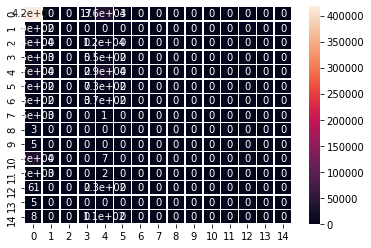

In [32]:
# model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

# evaluation
print('Accuracy: {}'.format(accuracy_score(y_test, lr_y_pred)))
c_matrix = confusion_matrix(y_test, lr_y_pred)
fig, ax = plt.subplots()
ax = sns.heatmap(c_matrix,annot=True,linewidths=.5)
plt.show()

In [33]:
eval_metrics(c_matrix)

 False Positives: 118603
 False Negatives: 118603
 True Positives: 446973
 True Negatives: 7799461 



Despite the high accuracy, we can see that it is unable to capture the true positives (only capturing 1/5). In addition, the cluster info also adds no difference for the 2 models. Hence, clustering might not be too effective with too many features together.

### Logistic Regression after downsampling generic network flows

In [34]:
# Re-concatenate our training and testing data to downsample majority benign traffic
X = pd.concat([X_train, y_train], axis=1)

# Separate different traffic flows
mal = X[X.label != 0]
ben = X[X.label == 0]

# Downsample majority
ben_downsample = resample(ben, replace=False, n_samples=len(mal), random_state=42)
downsampled_df = pd.concat([ben_downsample, mal])

# Result of downsampling
downsampled_df.label.value_counts()

0     445069
4     183865
10    127092
2     102437
3       8238
7       6365
11      4655
6       4650
5       4396
1       1570
12      1216
14       530
9         31
13        16
8          8
Name: label, dtype: int64

Accuracy: 0.6213205652290762


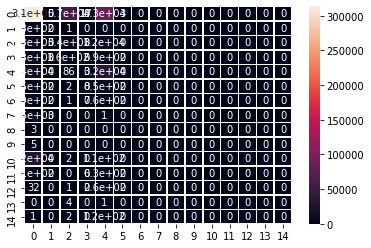

In [35]:
# Retrying logistic regression
y_train_ds = downsampled_df.label
X_train_ds = downsampled_df.drop('label', axis=1)

lr_model_ds = LogisticRegression(random_state=42).fit(X_train_ds, y_train_ds)
y_pred_ds = lr_model_ds.predict(X_test)

# evaluation
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_ds)))
c_matrix = confusion_matrix(y_test, y_pred_ds)
fig, ax = plt.subplots()
ax = sns.heatmap(c_matrix,annot=True,linewidths=.5)
plt.show()

In [36]:
eval_metrics(c_matrix)

 False Positives: 214172
 False Negatives: 214172
 True Positives: 351404
 True Negatives: 7703892 



> As you can see, the false negatives are greatly reduced whilst the false positives are greatly increased. Nevertheless, we have successfully picked up every single malignant traffic with the downsampled model!

## Random Forest, SVM and Decision Trees

### ID3 Decision Tree after KMeans clustering w/ downsampling

In one of the research papers, I read that ID3 decision trees are good for anomaly detection after factoring cluster info. Hence, I will try to use sklearn's decision tree algorithm to try and replicate the result.

Accuracy: 0.9973885030482199


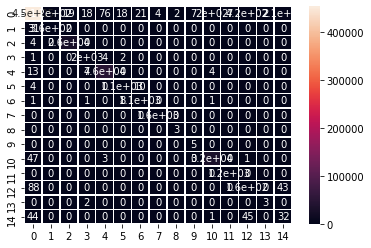

In [37]:
id3_tree_clf = tree.DecisionTreeClassifier()
id3_tree_clf.fit(X_train_ds, y_train_ds)
y_pred_id3_tree = id3_tree_clf.predict(X_test)

# evaluation
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_id3_tree)))
c_matrix = confusion_matrix(y_test, y_pred_id3_tree)
fig, ax = plt.subplots()
ax = sns.heatmap(c_matrix,annot=True,linewidths=.5)
plt.show()

As a result, the testing `infiltration` packets are all successfully identified. The amount of false positives have also been reduced dramatically.

### ID3 Decision Tree after KMeans clustering w/o downsampling

This model is worrisome as it has a high tendency to overfit due to its nature of generating a lot of layers down the tree. Nevertheless, we will test it out.

Accuracy: 0.9976820091375872


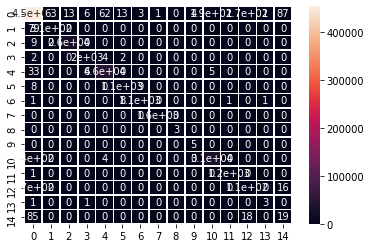

In [38]:
id3_tree_clf = tree.DecisionTreeClassifier()
id3_tree_clf.fit(X_train, y_train)
y_pred_id3_tree = id3_tree_clf.predict(X_test)

# evaluation
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_id3_tree)))
c_matrix = confusion_matrix(y_test, y_pred_id3_tree)
fig, ax = plt.subplots()
ax = sns.heatmap(c_matrix,annot=True,linewidths=.5)
plt.show()